1. Импорт библиотек

In [71]:
import time
from pathlib import Path
from typing import Optional
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

2. Выбор устройства для вычислений (CPU/GPU)

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Выбор устройства
print("Используется устройство:", device) # Вывод выбранного устройства

Используется устройство: cpu


3. Определение преобразований для данных

In [73]:
# Для MNIST (черно-белые изображения 28x28 с одним каналом)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Стандартные значения для MNIST
])

4. Загрузка и разделение датасета MNIST

In [74]:
# Основной датасет
trainset = torchvision.datasets.MNIST(
    root='./data', # Путь к данным
    train=True, # Тренировочный набор
    download=True, # Скачивание, если данных нет
    transform=transform # Преобразования к данным
)

testset = torchvision.datasets.MNIST(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

# Разделяем тренировочные данные на обучение и валидацию
train_dataset, val_dataset = random_split(trainset, [50000, 10000])

classes = [str(i) for i in range(10)]  # Классы для MNIST: цифры 0-9

5. Функция для визуализации изображений

In [75]:
def imshow(img):
    # Денормализация для MNIST
    img = img * 0.3081 + 0.1307 # Обратная нормализация
    npimg = img.numpy() # Преобразование в numpy
    plt.imshow(npimg.squeeze(), cmap='gray')  # Убираем размерность канала для grayscale
    plt.axis('off') # Отключаем оси


6. Определение архитектуры нейронной сети

In [76]:
class NeuralNetwork(nn.Module): # Определение архитектуры нейронной сети
    def __init__(self, input_size=28*28, hidden_size1=256, hidden_size2=128, num_classes=10, dropout_rate=0.2): # Параметры сети
        super(NeuralNetwork, self).__init__() # Инициализация родительского класса
        self.net = nn.Sequential( # Последовательная модель
            nn.Flatten(), # Преобразование входа в вектор
            nn.Linear(input_size, hidden_size1), # Первый полносвязный слой
            nn.BatchNorm1d(hidden_size1), # Нормализация
            nn.ReLU(), # Активация ReLU
            nn.Dropout(dropout_rate), # Dropout для регуляризации 
            
            nn.Linear(hidden_size1, hidden_size2),
            nn.BatchNorm1d(hidden_size2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(hidden_size2, num_classes)
        )
    
    def forward(self, x): # Прямой проход
        return self.net(x)

7. Функция для одного шага обучения

In [77]:
def train_step(model, dataloader, optimizer, criterion, device, epoch): # Функция для одного шага обучения
    model.train() # Режим тренировки
    running_loss = 0.0 # Суммарный лосс
    running_corrects = 0 # Суммарные правильные предсказания
    
    for inputs, labels in tqdm(dataloader, desc=f'Train Epoch {epoch}'): # Итерация по батчам
        inputs = inputs.to(device) # Перемещение на устройство
        labels = labels.to(device) 
        
        optimizer.zero_grad() # Обнуление градиентов
        outputs = model(inputs) # Прямой проход
        _, preds = torch.max(outputs, 1) # Предсказания
        loss = criterion(outputs, labels) # Вычисление лосса
        
        loss.backward() # Обратный проход
        optimizer.step() # Обновление весов
        
        running_loss += loss.item() * inputs.size(0) # Накопление лосса
        running_corrects += (preds == labels).sum().item() # Накопление правильных предсказаний
    
    epoch_loss = running_loss / len(dataloader.dataset) # Средний лосс за эпоху
    epoch_acc = running_corrects / len(dataloader.dataset) # Точность за эпоху
    
    return epoch_loss, epoch_acc

8. Функция для шага валидации

In [78]:
def val_step(model, dataloader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f'Val Epoch {epoch}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc


9. Реализация Early Stopping

In [79]:
class EarlyStopping: 
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True): # Инициализация
        self.patience = patience # Количество эпох без улучшения
        self.min_delta = min_delta # Минимальное улучшение для учета
        self.restore_best_weights = restore_best_weights # Флаг восстановления лучших весов
        self.best_loss = None # Лучший лосс
        self.counter = 0 # Счетчик эпох без улучшения
        self.best_model_weights = None # Лучшие веса модели
        
    def __call__(self, val_loss, model): # Проверка на остановку
        if self.best_loss is None: # Инициализация лучшего лосса
            self.best_loss = val_loss # Установка лучшего лосса
            self.save_model_weights(model) # Сохранение весов модели
        elif val_loss > self.best_loss - self.min_delta: # Проверка на улучшение
            self.counter += 1 # Увеличение счетчика
            if self.counter >= self.patience: # Проверка на превышение терпения
                if self.restore_best_weights: # Восстановление лучших весов
                    model.load_state_dict(self.best_model_weights) # Восстановление весов
                return True
        else:
            self.best_loss = val_loss # Обновление лучшего лосса
            self.counter = 0 # Сброс счетчика 
            self.save_model_weights(model) # Сохранение весов модели
        return False 
    
    def save_model_weights(self, model): # Сохранение весов модели
        self.best_model_weights = model.state_dict().copy() # Копирование весов модели

10. Основной цикл обучения

In [ ]:
def train_loop(model, start_epoch, end_epoch, optimizer, device, criterion,
               train_summary_writer, val_summary_writer, train_dataloader,
               val_dataloader, model_save_dir, best_acc=0.0, scheduler=None,
               early_stopping=None): # Основной цикл обучения
    current_best_acc = best_acc # Текущая лучшая точность
    
    for epoch in range(start_epoch, end_epoch):
        start_time = time.time() # Время начала эпохи
        
        # 1. ОБУЧЕНИЕ
        train_loss, train_accuracy = train_step(model, train_dataloader, optimizer, criterion, device, epoch) # Шаг обучения
        train_summary_writer.add_scalar('Loss/train', train_loss, epoch) # Логгирование лосса 
        train_summary_writer.add_scalar('Accuracy/train', train_accuracy, epoch) # Логгирование точности 
        
        # 2. ВАЛИДАЦИЯ
        val_loss, val_accuracy = val_step(model, val_dataloader, criterion, device, epoch) # Шаг валидации
        val_summary_writer.add_scalar('Loss/val', val_loss, epoch) # Логгирование лосса валидации
        val_summary_writer.add_scalar('Accuracy/val', val_accuracy, epoch) # Логгирование точности валидации 
        
        # 3. Шаг планировщика обучения (если передан)
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau): # Проверка типа планировщика
                scheduler.step(val_loss) # Шаг для ReduceLROnPlateau
            else:
                scheduler.step() # Шаг для остальных планировщиков
        
        # 4. СОХРАНЕНИЕ ЛУЧШЕЙ МОДЕЛИ
        if val_accuracy > current_best_acc: # Проверка на лучшую точность
            current_best_acc = val_accuracy # Обновление лучшей точности
            torch.save({
                'epoch': epoch, # Текущая эпоха
                'model_state_dict': model.state_dict(), # Состояние модели
                'optimizer_state_dict': optimizer.state_dict(), # Состояние оптимизатора
                'accuracy': val_accuracy, # Точность на валидации
                'loss': val_loss, # Лосс на валидации
            }, model_save_dir / 'best_model.pth') # Сохранение модели
            print(f"Epoch {epoch} | --------New best model saved with val_acc = {val_accuracy:.4f}") # Вывод сообщения о сохранении лучшей модели
        
        # 5. Early Stopping проверка
        if early_stopping: 
            if early_stopping(val_loss, model): # Вызов проверки
                print(f"Early stopping triggered at epoch {epoch}") # Сообщение о срабатывании
                break
        
        # 6. Сохранение последней модели
        torch.save({
            'epoch': epoch, # Текущая эпоха
            'model_state_dict': model.state_dict(), # Состояние модели
            'optimizer_state_dict': optimizer.state_dict(), # Состояние оптимизатора
            'accuracy': val_accuracy, # Точность на валидации
            'loss': val_loss, # Лосс на валидации
        }, model_save_dir / 'latest_model.pth') # Сохранение последней модели
        
        # 7. Статистика по эпохе
        epoch_time = time.time() - start_time # Время окончания эпохи
        current_lr = optimizer.param_groups[0]['lr'] # Текущая скорость обучения
        print(f"Epoch {epoch}/{end_epoch} | Time: {epoch_time:.2f}s | LR: {current_lr:.6f}") # Статистика по эпохе
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.4f}") # Лосс и точность на обучении
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}") # Лосс и точность на валидации
        print("-" * 60) # Разделитель для читаемости

11. Функция тестирования модели

In [ ]:
def test_model(model, test_loader, device, classes): # Функция для тестирования модели и построения матрицы ошибок
    model.eval() # Режим оценки
    all_preds = [] # Список для всех предсказаний
    all_labels = [] # Список для всех истинных меток
    test_correct = 0 # Счетчик правильных предсказаний
    test_total = 0 # Общее количество предсказаний
    
    with torch.no_grad(): # Отключение градиентов
        for inputs, labels in tqdm(test_loader, desc='Testing'): # Итерация по тестовому набору
            inputs = inputs.to(device) # Перемещение на устройство
            labels = labels.to(device) 
            
            outputs = model(inputs) # Прямой проход
            _, preds = torch.max(outputs, 1) # Предсказания
            
            all_preds.extend(preds.cpu().numpy()) # Сохранение предсказаний
            all_labels.extend(labels.cpu().numpy()) # Сохранение истинных меток
            
            test_correct += (preds == labels).sum().item() # Подсчет правильных предсказаний
            test_total += labels.size(0) # Подсчет общего количества предсказаний 
    
    test_accuracy = test_correct / test_total # Вычисление точности
    
    # Построение матрицы ошибок
    cm = confusion_matrix(all_labels, all_preds) # Вычисление матрицы ошибок
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    return test_accuracy, all_preds, all_labels # Возврат точности, предсказаний и истинных меток

12. Функция для визуализации прогнозов

In [ ]:
def visualize_predictions(model, test_loader, device, classes, num_images=10): # Функция для визуализации предсказаний модели
    model.eval() # Режим оценки
    images, labels = next(iter(test_loader)) # Получение одного батча
    images, labels = images[:num_images].to(device), labels[:num_images].to(device) # Ограничение по количеству изображений 
    
    with torch.no_grad(): # Отключение градиентов
        outputs = model(images) # Прямой проход
        _, preds = torch.max(outputs, 1) # Предсказания
    
    images = images.cpu() # Перемещение изображений на CPU для визуализации
    fig, axes = plt.subplots(2, 5, figsize=(12, 6)) # Создание сетки для отображения изображений
    axes = axes.ravel() # Выравнивание осей в одномерный массив
    
    for i in range(num_images): # Итерация по изображениям
        axes[i].imshow(images[i].squeeze(), cmap='gray') # Отображение изображения
        axes[i].set_title(f'True: {classes[labels[i]]}, Pred: {classes[preds[i]]}') # Заголовок с истинной и предсказанной меткой 
        axes[i].axis('off') # Отключение осей 
        if labels[i] != preds[i]: # Если предсказание неверно
            axes[i].title.set_color('red') # Цвет заголовка красный для неверных предсказаний
    
    plt.tight_layout()
    plt.show()

13. Grid Search для гиперпараметров

In [ ]:
def grid_search(): # Функция для перебора гиперпараметров
    learning_rates = [0.001, 0.01, 0.1] # Различные скорости обучения
    batch_sizes = [32, 64, 128] # Различные размеры батчей
    optimizers_list = ['Adam', 'SGD'] # Различные оптимизаторы
    
    best_accuracy = 0 # Лучшая точность
    best_params = {} # Лучшие параметры
    
    for lr in learning_rates: # Перебор скоростей обучения
        for batch_size in batch_sizes: # Перебор размеров батчей
            for opt_name in optimizers_list: # Перебор оптимизаторов 
                print(f"\n=== Testing LR: {lr}, Batch Size: {batch_size}, Optimizer: {opt_name} ===") # Вывод текущих параметров
                
                # Создание DataLoader'ов
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Тренировочный DataLoader
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Валидационный DataLoader
                 
                # Создание модели
                model = NeuralNetwork().to(device) # Инициализация модели
                
                # Выбор оптимизатора
                if opt_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam оптимизатор
                else:
                    optimizer = optim.SGD(model.parameters(), lr=lr) # SGD оптимизатор
                
                criterion = nn.CrossEntropyLoss() # Кросс-энтропийный лосс
                
                # Быстрое обучение для оценки
                current_best = 0 # Лучшая точность для текущих параметров
                for epoch in range(3):  # Всего 3 эпохи для быстрой оценки
                    train_loss, train_acc = train_step(model, train_loader, optimizer, criterion, device, epoch) # Шаг обучения
                    val_loss, val_acc = val_step(model, val_loader, criterion, device, epoch) # Шаг валидации
                    
                    if val_acc > current_best: # Проверка на лучшую точность
                        current_best = val_acc # Обновление лучшей точности
                
                print(f"Best validation accuracy: {current_best:.4f}") # Вывод лучшей точности
                
                if current_best > best_accuracy: # Проверка на глобальную лучшую точность
                    best_accuracy = current_best # Обновление глобальной лучшей точности
                    best_params = {
                        'learning_rate': lr, # Лучшая скорость обучения
                        'batch_size': batch_size, # Лучший размер батча
                        'optimizer': opt_name # Лучший оптимизатор
                    }
    
    print(f"\nBest parameters: {best_params}")
    print(f"Best accuracy: {best_accuracy:.4f}")
    return best_params # Возврат лучших параметров

14. Основной блок выполнения

In [ ]:
def main(): # Основная функция для запуска всего процесса
    # Создание директорий для сохранения
    save_dir = Path('./checkpoints') # Директория для чекпоинтов
    save_dir.mkdir(parents=True, exist_ok=True) # Создание директории, если не существует
    
    log_dir = Path('./runs/mnist_experiment') # Директория для логов TensorBoard
    log_dir.mkdir(parents=True, exist_ok=True) # Создание директории, если не существует
    
    # Гиперпараметры
    batch_size = 64 # Размер батча
    learning_rate = 0.001 # Скорость обучения
    num_epochs = 20 # Количество эпох 
    
    # Создание DataLoader'ов
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # Тренировочный DataLoader
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2) # Валидационный DataLoader
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2) # Тестовый DataLoader
    
    # Визуализация примеров данных
    print("Визуализация примеров изображений из датасета:")
    data_iter = iter(train_loader) # Итератор по тренировочному DataLoader
    images, labels = next(data_iter) # Получение одного батча
    
    plt.figure(figsize=(12, 6)) 
    for i in range(10): # Отображение первых 10 изображений
        plt.subplot(2, 5, i+1)
        imshow(images[i])
        plt.title(f'Class: {classes[labels[i]]}')
        plt.axis('off')
    plt.suptitle("Примеры изображений из MNIST")
    plt.tight_layout()
    plt.show()
    
    # Создание модели
    model = NeuralNetwork().to(device) # Инициализация модели
    print(f"Модель создана. Параметров: {sum(p.numel() for p in model.parameters()):,}") # Вывод количества параметров
    
    # Оптимизатор и функция потерь
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # Adam оптимизатор
    criterion = nn.CrossEntropyLoss() # Кросс-энтропийный лосс 
    
    # Планировщик обучения
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3) # Планировщик снижения LR при плато
    
    # Early Stopping
    early_stopping = EarlyStopping(patience=5, min_delta=0.001) # Инициализация Early Stopping
    
    # TensorBoard writers
    train_writer = SummaryWriter(log_dir / 'train') # Логгирование для тренировочного набора
    val_writer = SummaryWriter(log_dir / 'val') # Логгирование для валидационного набора
    
    print("Начало обучения...")
    
    # Запуск обучения
    train_loop( 
        model=model, # Модель для обучения
        start_epoch=0, # Начальная эпоха 
        end_epoch=num_epochs, # Конечная эпоха
        optimizer=optimizer, # Оптимизатор
        device=device, # Устройство
        criterion=criterion, # Функция потерь
        train_summary_writer=train_writer, # TensorBoard writer для тренировки
        val_summary_writer=val_writer, # TensorBoard writer для валидации
        train_dataloader=train_loader, # Тренировочный DataLoader
        val_dataloader=val_loader, # Валидационный DataLoader
        model_save_dir=save_dir, # Директория для сохранения модели 
        best_acc=0.0, # Лучшая точность
        scheduler=scheduler, # Планировщик обучения
        early_stopping=early_stopping # Early Stopping 
    )
    
    # Загрузка лучшей модели для тестирования
    checkpoint = torch.load(save_dir / 'best_model.pth') # Загрузка чекпоинта
    model.load_state_dict(checkpoint['model_state_dict']) # Загрузка состояния модели
    print(f"Загружена лучшая модель с эпохи {checkpoint['epoch']}, accuracy = {checkpoint['accuracy']:.4f}")
    
    # Тестирование модели
    print("\nТестирование на тестовой выборке...")
    test_accuracy, all_preds, all_labels = test_model(model, test_loader, device, classes) # Тестирование модели
    print(f"Точность на тестовой выборке: {test_accuracy:.4f}")
    
    # Визуализация прогнозов
    visualize_predictions(model, test_loader, device, classes) # Визуализация предсказаний
    
    # Закрытие TensorBoard writers
    train_writer.close()
    val_writer.close()
    
    print(f"\n=== РЕЗУЛЬТАТЫ ===")
    print(f"Лучшая точность на валидации: {checkpoint['accuracy']:.4f}")
    print(f"Точность на тесте: {test_accuracy:.4f}")
    
    # Grid Search (опционально)
    print("\n=== ЗАПУСК GRID SEARCH ===")
    best_params = grid_search()
    
    return model, test_accuracy, best_params


15. Дополнительное задание: FashionMNIST

In [ ]:
def fashion_mnist_experiment(): # Дополнительное задание с FashionMNIST
    print("\n" + "="*60)
    print("ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ: EXPERIMENT WITH FASHIONMNIST")
    print("="*60)
    
    # Преобразования для FashionMNIST
    transform_fashion = transforms.Compose([ 
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,))  # Значения для FashionMNIST
    ])
    
    # Загрузка FashionMNIST
    fashion_trainset = torchvision.datasets.FashionMNIST( # Тренировочный набор
        root='./data', 
        train=True,
        download=True, 
        transform=transform_fashion
    )
    
    fashion_testset = torchvision.datasets.FashionMNIST( # Тестовый набор
        root='./data', 
        train=False,
        download=True, 
        transform=transform_fashion
    )
    
    fashion_train, fashion_val = random_split(fashion_trainset, [50000, 10000]) # Разделение на обучение и валидацию
    fashion_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
                      'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # Классы FashionMNIST
    
    # DataLoader'ы
    fashion_train_loader = DataLoader(fashion_train, batch_size=64, shuffle=True) # Тренировочный DataLoader
    fashion_val_loader = DataLoader(fashion_val, batch_size=64, shuffle=False) # Валидационный DataLoader
    fashion_test_loader = DataLoader(fashion_testset, batch_size=64, shuffle=False) # Тестовый DataLoader 
    
    # Модель
    fashion_model = NeuralNetwork().to(device) # Инициализация модели 
    fashion_optimizer = optim.Adam(fashion_model.parameters(), lr=0.001)    # Adam оптимизатор
    fashion_criterion = nn.CrossEntropyLoss()   # Кросс-энтропийный лосс
    
    print("Обучение на FashionMNIST...")
    
    # Быстрое обучение (5 эпох)
    for epoch in range(5):
        train_loss, train_acc = train_step(fashion_model, fashion_train_loader, 
                                         fashion_optimizer, fashion_criterion, device, epoch) # Шаг обучения
        val_loss, val_acc = val_step(fashion_model, fashion_val_loader, 
                                   fashion_criterion, device, epoch) # Шаг валидации
        print(f"Epoch {epoch}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    # Тестирование
    fashion_accuracy, _, _ = test_model(fashion_model, fashion_test_loader, device, fashion_classes)
    print(f"Точность на FashionMNIST: {fashion_accuracy:.4f}")
    
    return fashion_accuracy

16. Запуск основной программы

Визуализация примеров изображений из датасета:


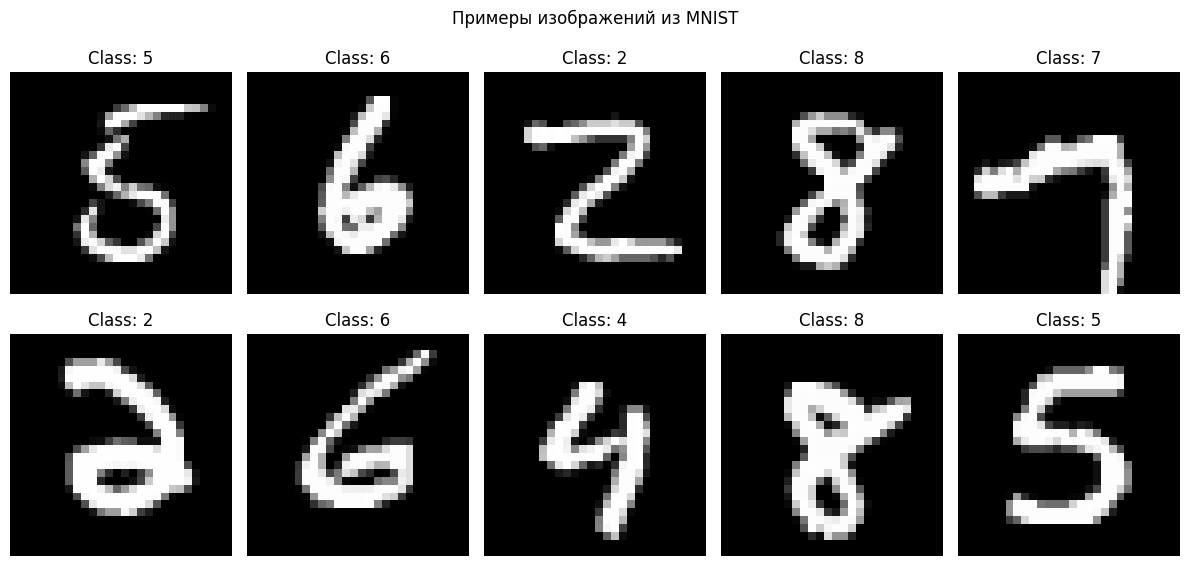

Модель создана. Параметров: 235,914
Начало обучения...


Val Epoch 0: 100%|██████████| 157/157 [00:05<00:00, 27.56it/s] 


Epoch 0 | ✅ New best model saved with val_acc = 0.9678
Epoch 0/20 | Time: 20.31s | LR: 0.001000
  Train Loss: 0.2826 | Train Acc: 0.9216
  Val Loss: 0.1115 | Val Acc: 0.9678
------------------------------------------------------------


Val Epoch 1: 100%|██████████| 157/157 [00:05<00:00, 27.98it/s] 


Epoch 1 | ✅ New best model saved with val_acc = 0.9743
Epoch 1/20 | Time: 19.80s | LR: 0.001000
  Train Loss: 0.1340 | Train Acc: 0.9592
  Val Loss: 0.0885 | Val Acc: 0.9743
------------------------------------------------------------


Val Epoch 2: 100%|██████████| 157/157 [00:05<00:00, 28.21it/s] 


Epoch 2 | ✅ New best model saved with val_acc = 0.9769
Epoch 2/20 | Time: 19.96s | LR: 0.001000
  Train Loss: 0.1036 | Train Acc: 0.9680
  Val Loss: 0.0808 | Val Acc: 0.9769
------------------------------------------------------------


Val Epoch 3: 100%|██████████| 157/157 [00:05<00:00, 27.37it/s] 


Epoch 3 | ✅ New best model saved with val_acc = 0.9770
Epoch 3/20 | Time: 19.85s | LR: 0.001000
  Train Loss: 0.0873 | Train Acc: 0.9720
  Val Loss: 0.0764 | Val Acc: 0.9770
------------------------------------------------------------


Val Epoch 4: 100%|██████████| 157/157 [00:05<00:00, 28.38it/s] 


Epoch 4 | ✅ New best model saved with val_acc = 0.9789
Epoch 4/20 | Time: 19.77s | LR: 0.001000
  Train Loss: 0.0759 | Train Acc: 0.9757
  Val Loss: 0.0717 | Val Acc: 0.9789
------------------------------------------------------------


Val Epoch 5: 100%|██████████| 157/157 [00:05<00:00, 28.58it/s] 


Epoch 5/20 | Time: 19.88s | LR: 0.001000
  Train Loss: 0.0680 | Train Acc: 0.9779
  Val Loss: 0.0750 | Val Acc: 0.9784
------------------------------------------------------------


Val Epoch 6: 100%|██████████| 157/157 [00:05<00:00, 28.59it/s] 


Epoch 6 | ✅ New best model saved with val_acc = 0.9794
Epoch 6/20 | Time: 19.48s | LR: 0.001000
  Train Loss: 0.0601 | Train Acc: 0.9805
  Val Loss: 0.0710 | Val Acc: 0.9794
------------------------------------------------------------


Val Epoch 7: 100%|██████████| 157/157 [00:05<00:00, 28.04it/s] 


Epoch 7 | ✅ New best model saved with val_acc = 0.9812
Epoch 7/20 | Time: 19.63s | LR: 0.001000
  Train Loss: 0.0541 | Train Acc: 0.9816
  Val Loss: 0.0698 | Val Acc: 0.9812
------------------------------------------------------------


Val Epoch 8: 100%|██████████| 157/157 [00:05<00:00, 28.43it/s] 


Epoch 8/20 | Time: 19.60s | LR: 0.001000
  Train Loss: 0.0483 | Train Acc: 0.9842
  Val Loss: 0.0703 | Val Acc: 0.9803
------------------------------------------------------------


Val Epoch 9: 100%|██████████| 157/157 [00:05<00:00, 28.62it/s] 


Epoch 9 | ✅ New best model saved with val_acc = 0.9814
Epoch 9/20 | Time: 19.34s | LR: 0.001000
  Train Loss: 0.0477 | Train Acc: 0.9843
  Val Loss: 0.0685 | Val Acc: 0.9814
------------------------------------------------------------


Val Epoch 10: 100%|██████████| 157/157 [00:05<00:00, 28.59it/s] 


Epoch 10 | ✅ New best model saved with val_acc = 0.9819
Epoch 10/20 | Time: 19.54s | LR: 0.001000
  Train Loss: 0.0423 | Train Acc: 0.9856
  Val Loss: 0.0677 | Val Acc: 0.9819
------------------------------------------------------------


Val Epoch 11: 100%|██████████| 157/157 [00:05<00:00, 27.16it/s] 


Epoch 11/20 | Time: 20.18s | LR: 0.001000
  Train Loss: 0.0400 | Train Acc: 0.9864
  Val Loss: 0.0697 | Val Acc: 0.9818
------------------------------------------------------------


Val Epoch 12: 100%|██████████| 157/157 [00:05<00:00, 28.72it/s] 


Epoch 12 | ✅ New best model saved with val_acc = 0.9828
Epoch 12/20 | Time: 19.61s | LR: 0.001000
  Train Loss: 0.0377 | Train Acc: 0.9868
  Val Loss: 0.0639 | Val Acc: 0.9828
------------------------------------------------------------


Val Epoch 13: 100%|██████████| 157/157 [00:06<00:00, 25.38it/s] 


Epoch 13/20 | Time: 21.52s | LR: 0.001000
  Train Loss: 0.0338 | Train Acc: 0.9888
  Val Loss: 0.0719 | Val Acc: 0.9825
------------------------------------------------------------


Val Epoch 14: 100%|██████████| 157/157 [00:05<00:00, 27.31it/s] 


Epoch 14 | ✅ New best model saved with val_acc = 0.9832
Epoch 14/20 | Time: 21.02s | LR: 0.001000
  Train Loss: 0.0327 | Train Acc: 0.9890
  Val Loss: 0.0661 | Val Acc: 0.9832
------------------------------------------------------------


Val Epoch 15: 100%|██████████| 157/157 [00:05<00:00, 26.93it/s] 


Epoch 15/20 | Time: 20.29s | LR: 0.001000
  Train Loss: 0.0314 | Train Acc: 0.9894
  Val Loss: 0.0689 | Val Acc: 0.9832
------------------------------------------------------------


Val Epoch 16: 100%|██████████| 157/157 [00:06<00:00, 26.03it/s] 


Epoch 16 | ✅ New best model saved with val_acc = 0.9834
Epoch 16/20 | Time: 20.73s | LR: 0.000500
  Train Loss: 0.0295 | Train Acc: 0.9902
  Val Loss: 0.0692 | Val Acc: 0.9834
------------------------------------------------------------


Val Epoch 17: 100%|██████████| 157/157 [00:05<00:00, 27.40it/s] 


Epoch 17 | ✅ New best model saved with val_acc = 0.9840
Early stopping triggered at epoch 17
Загружена лучшая модель с эпохи 17, accuracy = 0.9840

Тестирование на тестовой выборке...


Testing: 100%|██████████| 157/157 [00:05<00:00, 27.74it/s] 


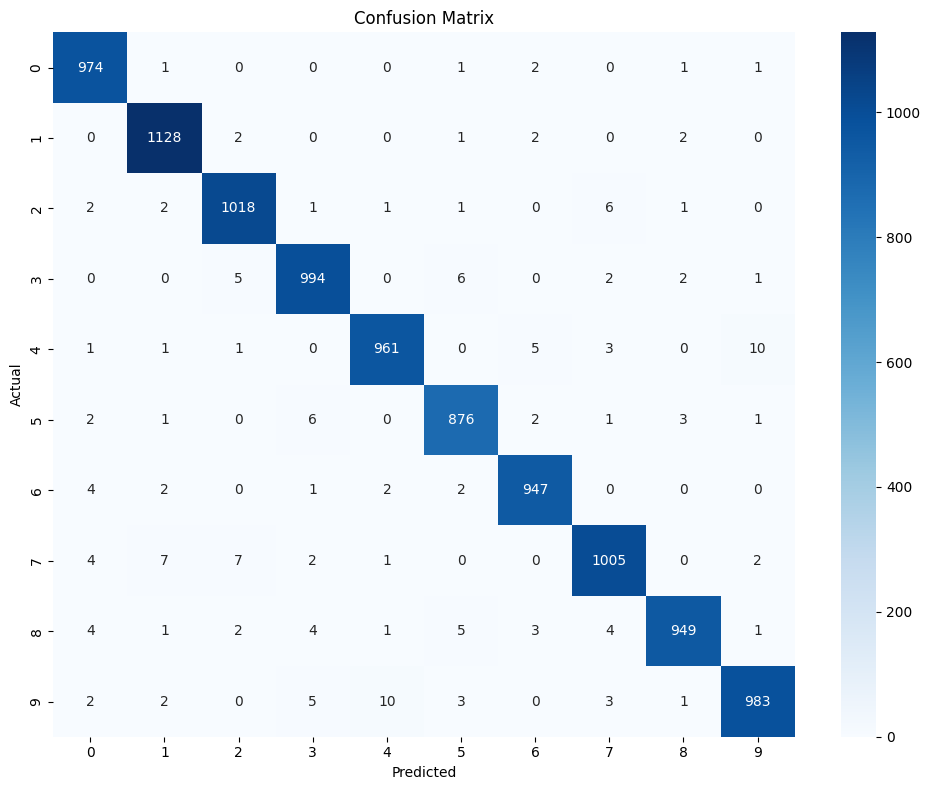

Точность на тестовой выборке: 0.9835


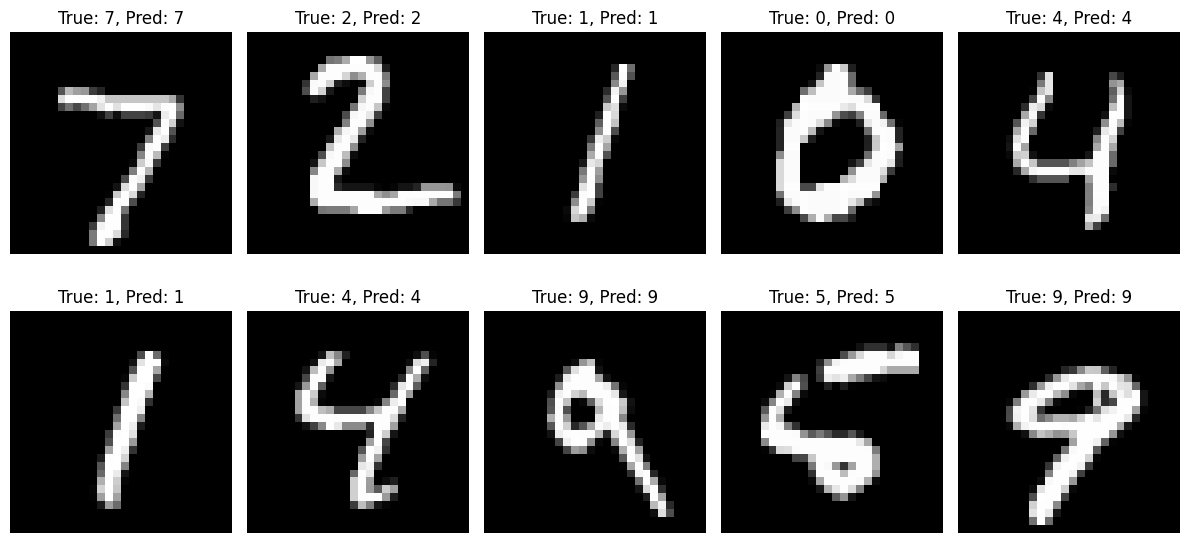


=== РЕЗУЛЬТАТЫ ===
Лучшая точность на валидации: 0.9840
Точность на тесте: 0.9835

=== ЗАПУСК GRID SEARCH ===

=== Testing LR: 0.001, Batch Size: 32, Optimizer: Adam ===


Val Epoch 2: 100%|██████████| 313/313 [00:02<00:00, 125.07it/s]


Best validation accuracy: 0.9772

=== Testing LR: 0.001, Batch Size: 32, Optimizer: SGD ===


Val Epoch 2: 100%|██████████| 313/313 [00:02<00:00, 118.53it/s]


Best validation accuracy: 0.9139

=== Testing LR: 0.001, Batch Size: 64, Optimizer: Adam ===


Val Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 64.10it/s]


Best validation accuracy: 0.9762

=== Testing LR: 0.001, Batch Size: 64, Optimizer: SGD ===


Val Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 64.84it/s]


Best validation accuracy: 0.8858

=== Testing LR: 0.001, Batch Size: 128, Optimizer: Adam ===


Val Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 32.10it/s]


Best validation accuracy: 0.9758

=== Testing LR: 0.001, Batch Size: 128, Optimizer: SGD ===


Val Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 35.64it/s]


Best validation accuracy: 0.8477

=== Testing LR: 0.01, Batch Size: 32, Optimizer: Adam ===


Val Epoch 2: 100%|██████████| 313/313 [00:02<00:00, 124.26it/s]


Best validation accuracy: 0.9728

=== Testing LR: 0.01, Batch Size: 32, Optimizer: SGD ===


Val Epoch 2: 100%|██████████| 313/313 [00:02<00:00, 133.09it/s]


Best validation accuracy: 0.9683

=== Testing LR: 0.01, Batch Size: 64, Optimizer: Adam ===


Val Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 67.21it/s]


Best validation accuracy: 0.9746

=== Testing LR: 0.01, Batch Size: 64, Optimizer: SGD ===


Val Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 65.78it/s]


Best validation accuracy: 0.9582

=== Testing LR: 0.01, Batch Size: 128, Optimizer: Adam ===


Val Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 34.78it/s]


Best validation accuracy: 0.9731

=== Testing LR: 0.01, Batch Size: 128, Optimizer: SGD ===


Val Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 36.13it/s]


Best validation accuracy: 0.9398

=== Testing LR: 0.1, Batch Size: 32, Optimizer: Adam ===


Val Epoch 2: 100%|██████████| 313/313 [00:02<00:00, 115.19it/s]


Best validation accuracy: 0.9500

=== Testing LR: 0.1, Batch Size: 32, Optimizer: SGD ===


Val Epoch 2: 100%|██████████| 313/313 [00:02<00:00, 125.81it/s]


Best validation accuracy: 0.9750

=== Testing LR: 0.1, Batch Size: 64, Optimizer: Adam ===


Val Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 68.15it/s]


Best validation accuracy: 0.9625

=== Testing LR: 0.1, Batch Size: 64, Optimizer: SGD ===


Val Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 67.05it/s]


Best validation accuracy: 0.9726

=== Testing LR: 0.1, Batch Size: 128, Optimizer: Adam ===


Val Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 28.94it/s]


Best validation accuracy: 0.9618

=== Testing LR: 0.1, Batch Size: 128, Optimizer: SGD ===


Val Epoch 2: 100%|██████████| 79/79 [00:02<00:00, 32.33it/s]


Best validation accuracy: 0.9725

Best parameters: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam'}
Best accuracy: 0.9772

ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ: EXPERIMENT WITH FASHIONMNIST


100.0%
100.0%
100.0%
100.0%


Обучение на FashionMNIST...


Val Epoch 0: 100%|██████████| 157/157 [00:02<00:00, 66.38it/s]


Epoch 0: Train Acc: 0.8218, Val Acc: 0.8478


Val Epoch 1: 100%|██████████| 157/157 [00:02<00:00, 67.65it/s]


Epoch 1: Train Acc: 0.8590, Val Acc: 0.8675


Val Epoch 2: 100%|██████████| 157/157 [00:02<00:00, 69.78it/s]


Epoch 2: Train Acc: 0.8719, Val Acc: 0.8742


Val Epoch 3: 100%|██████████| 157/157 [00:02<00:00, 69.27it/s]


Epoch 3: Train Acc: 0.8810, Val Acc: 0.8738


Val Epoch 4: 100%|██████████| 157/157 [00:02<00:00, 70.16it/s]


Epoch 4: Train Acc: 0.8859, Val Acc: 0.8764


Testing: 100%|██████████| 157/157 [00:02<00:00, 70.57it/s]


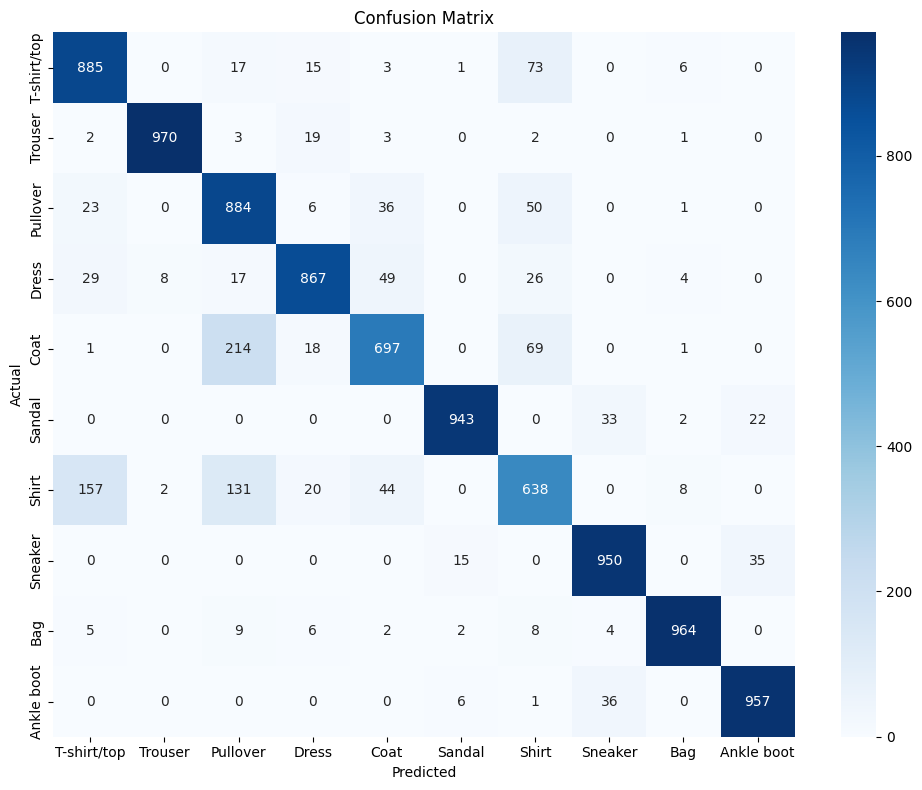

Точность на FashionMNIST: 0.8755

ИТОГОВЫЕ РЕЗУЛЬТАТЫ
MNIST Test Accuracy: 0.9835
FashionMNIST Test Accuracy: 0.8755
Лучшие параметры из Grid Search: {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'Adam'}

ИНСТРУКЦИЯ ДЛЯ TENSORBOARD
Для просмотра графиков в TensorBoard выполните в терминале:
tensorboard --logdir ./runs/mnist_experiment

Или в Jupyter Notebook:
%load_ext tensorboard
%tensorboard --logdir ./runs/mnist_experiment


In [ ]:

# Основной эксперимент с MNIST
model, test_accuracy, best_params = main()
    
    
# Дополнительный эксперимент с FashionMNIST
fashion_accuracy = fashion_mnist_experiment()
    
print("\n" + "="*60)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*60)
print(f"MNIST Test Accuracy: {test_accuracy:.4f}")
print(f"FashionMNIST Test Accuracy: {fashion_accuracy:.4f}")
print(f"Лучшие параметры из Grid Search: {best_params}")
    
# Инструкция для TensorBoard
print("Для просмотра графиков в TensorBoard выполните в терминале:")
print("tensorboard --logdir ./runs/mnist_experiment")
print("\nИли в Jupyter Notebook:")
print("%load_ext tensorboard")
print("%tensorboard --logdir ./runs/mnist_experiment")
    
    

# Итоговые выводы по эксперименту

## MNIST

- **Точность на тестовой выборке:**  
  MNIST Test Accuracy: 0.9835

- **Лучшая точность на валидации:**  
  Best validation accuracy: 0.9772

- **Лучшие параметры по результатам Grid Search:**  
  - Learning rate: 0.001
  - Batch size: 32
  - Optimizer: Adam

## FashionMNIST

- **Точность на тестовой выборке:**  
  FashionMNIST Test Accuracy: 0.8755

---

## Общие замечания

- Модель успешно обучается и на MNIST, и на FashionMNIST.
- Используется ранняя остановка (Early Stopping) и автоматическое снижение learning rate.
- Визуализация confusion matrix и предсказаний помогает анализировать ошибки модели.
- Для подбора гиперпараметров реализован простой Grid Search.

## Как посмотреть логи в TensorBoard

Выполните в терминале:
```
tensorboard --logdir ./runs/mnist_experiment
```
или в Jupyter Notebook:
```
%load_ext tensorboard
%tensorboard --logdir ./runs/mnist_experiment
```